Image Classification for Agriculture: A CNN Approach to Crop Health Monitoring

# 1. Project Overview and Objective

**Project Goal:** Convolutional Neural Network for Plant Disease Classification

The development of a **Convolutional Neural Network (CNN)** classifier designed to accurately **predict plant diseases** from **leaf images**. Leveraging `TensorFlow` and `Keras`, the objective was to build a model capable of supporting farmers and agricultural specialists in early disease detection, thereby minimizing crop loss and maximizing yield.

PATH Constants

In [1]:
# root directory for images
PLANT_DECEASE_IMAGES = "/content/drive/MyDrive/ColabNotebooks/30days/Dead_Plant_Prediction/Plant_images"

# specific plant images
POTATO_IMAGES = "/content/drive/MyDrive/ColabNotebooks/30days/Dead_Plant_Prediction/Plant_images/Potato_Early_blight"

# to save and import model
MODEL_PATH = "/content/drive/MyDrive/ColabNotebooks/30days/Dead_Plant_Prediction/Model"

# 2. Environment Setup and Data Ingestion
Data Ingestion and Access
To facilitate training within a GPU-accelerated environment, the image dataset was hosted on Google Drive and mounted to the Google Colab environment. The required input data for model training is located within the Plant_images directory.

In [2]:
# Load the Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Core Library Dependencies
The following essential libraries were imported for image processing, data preparation, and model construction:

Data Handling: numpy, os, cv2, and PIL (for image manipulation).

Deep Learning (CNN): tensorflow.keras, including essential layers (Conv2D, MaxPooling2D, Dense) and optimizers (Adam).

Preprocessing: sklearn for LabelBinarizer and train_test_split.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os
from os import listdir
from PIL import Image
from sklearn.preprocessing import label_binarize,  LabelBinarizer
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras.utils import to_categorical

# 3. Data Exploration and Preprocessing
Exploratory Data Analysis (EDA)
An initial visual inspection of the dataset was performed to understand the characteristics of the images, including their typical dimensions and the quality of the class-specific examples.

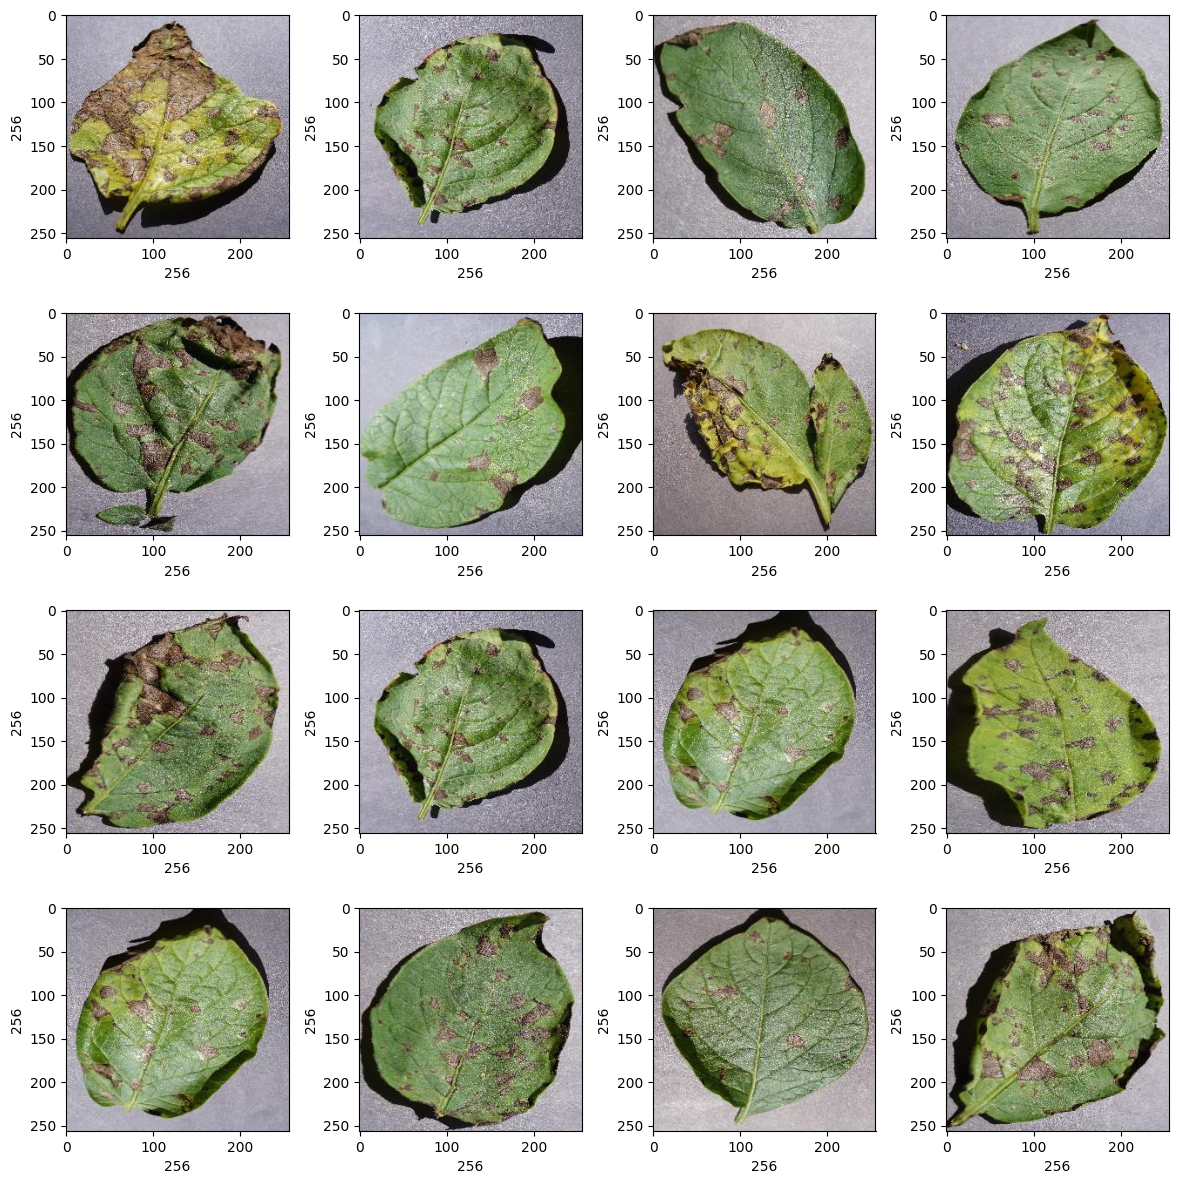

In [4]:
# Plotting 12 images to check dataset
plt.figure(figsize=(12,12))
path = POTATO_IMAGES
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

Each Image has 256x256 pixels.

## Data Preparation

**Image Standardization**: All images were resized to a uniform input dimension and converted into numerical arrays, pairing each array with its corresponding disease label .

In [5]:
# Images to array
def convert_image_to_array(dir):
    try:
        image = cv2.imread(dir)
        if image is not None :
            image = cv2.resize(image, (256,256))
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

To convert images to array, using the DIR. name as input and an numpy array as output

In [6]:
root_dir = listdir(PLANT_DECEASE_IMAGES)
image_list, label_list = [], []
all_labels = ['Tomato_Bacterial_spot', 'Potato_Early_blight', 'Maize_Common_rust']
class_labels = [0,1,2]
temp = -1

# Reading and converting image to numpy array
for directory in root_dir:
  plant_image_list = listdir(f"{PLANT_DECEASE_IMAGES}/{directory}")
  temp += 1
  for files in plant_image_list:
    image_path = f"{PLANT_DECEASE_IMAGES}/{directory}/{files}"
    image_list.append(convert_image_to_array(image_path))
    label_list.append(class_labels[temp])

Now we will convert all the images into numpy array.

In [7]:
print(root_dir) # order the folders where read by (0,1,2) the for loop

['Tomato_Bacterial_spot', 'Potato_Early_blight', 'Maize_Common_rust']


Lables:
- Tomato_Bacterial_spot as 0
- Potato_Early_blight as 1
- Maize_Common_rust as 2

In [8]:
# Visualize the number of classes count
label_counts = pd.DataFrame(label_list).value_counts()
label_counts.head()

,count
0,
0,300
1,300
2,300


The number of images under different classes shows that, the dataset is balanced.

In [9]:
image_list[0].shape

(256, 256, 3)

Checking the shape of a image after standardizing.

In [10]:
label_list = np.array(label_list)
label_list.shape

(900,)

Total number of the images which is the length of the labels list.

In [11]:
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state = 10)

Using sklearn train_test_split to split the dataset into testing and training data. Here I have taken test size as 0.2 so my data will be divided into 80% training and 20% testing data.

**Normalization:** The image pixel values (range 0-255) were normalized by dividing by 255.

In [12]:
x_train = np.array(x_train, dtype=np.float16) / 225.0
x_test = np.array(x_test, dtype=np.float16) / 225.0
x_train = x_train.reshape( -1, 256,256,3)
x_test = x_test.reshape( -1, 256,256,3)

This scales the features to the range [0, 1], which is a critical step for improving the convergence speed and stability of the neural network.

**Label Encoding:** Categorical disease labels were converted into a one-hot encoded format (using to_categorical) to align with the requirements of the final output layer.

In [13]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# 4. CNN Model Architecture and Training

Model Architecture Design

A sequential CNN model was constructed to learn hierarchical features from the input images:

In [14]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same",input_shape=(256,256,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(16, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(8, activation="relu"))
model.add(Dense(3, activation="softmax"))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 85, 85, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 85, 85, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 42, 42, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28224)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │       225,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231,347 (903.70 KB)

 Trainable params: 231,347 (903.70 KB)

 Non-trainable params: 0 (0.00 B)



**Convolutional Blocks:** The architecture utilizes two main convolutional blocks, with the first block employing 32 filters and the second using 16 filters (both with 3x3 kernels).

**Pooling:** Max Pooling layers were used after each convolution to downsample feature maps, which reduces computational load and extracts the most relevant features.

**Output Layer:** The network concludes with a `Flatten()` layer followed by a dense layer (8 units, ReLU), and a final output layer with 3 units and a Softmax activation for multi-class probability prediction.

In [15]:
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

Model Compilation and Training Execution

The model was compiled using the Adam optimizer and the categorical cross-entropy loss function. The model was trained for 50 epochs to ensure full convergence, with performance continuously monitored against a validation set.

In [16]:
# Splitting the training data set into training and validation data sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

Spliting the dataset into validation and training data.

In [17]:
# Training the model
epochs = 50
batch_size = 128
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs,
                    validation_data = (x_val, y_val))

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.3853 - loss: 1.0604 - val_accuracy: 0.5069 - val_loss: 0.9871
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.5157 - loss: 0.9803 - val_accuracy: 0.6528 - val_loss: 0.9239
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.6799 - loss: 0.8838 - val_accuracy: 0.6528 - val_loss: 0.8530
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.6736 - loss: 0.8075 - val_accuracy: 0.6528 - val_loss: 0.7839
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.6713 - loss: 0.7386 - val_accuracy: 0.6528 - val_loss: 0.7262
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.6567 - loss: 0.6938 - val_accuracy: 0.6528 - val_loss: 0.6753
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.6644 - loss: 0.6484 - val_accuracy: 0.6528 - val_loss: 0.6341
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.6614 - loss: 0.6204 - val_accuracy: 0.6528 - val_loss: 0

You can try using more number of epochs to increase accuracy but here, see that the model has already raeched a very high accuracy so no need for that.

During each epochs see how the model is performing by viewing the training and validation accuracy.

In [18]:
model.save(MODEL_PATH + '/plant_disease.keras')
# serialize model to json
json_model = model.to_json()

#save the model architecture to JSON file
with open(MODEL_PATH + '/plant_disease_model.json', 'w') as json_file:
    json_file.write(json_model)

#saving the weights of the model
model.save_weights(MODEL_PATH + '/plant_disease_model.weights.h5')

Saving the model using different techniques.

# 5. Performance Evaluation and Conclusion

Performance Metrics

The trained model was evaluated on the held-out test set to quantify its generalization capability:

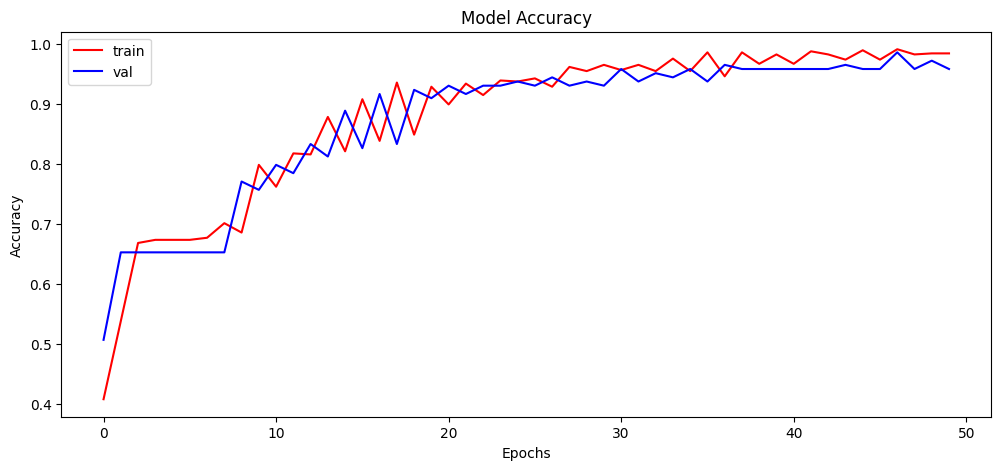

In [19]:
#Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

The accuracy of the model from the trainig history.

In [20]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.9620 - loss: 0.3987
Test Accuracy: 96.11111283302307


Evaluating the model to know the accuracy of the model.


In [21]:
y_pred = model.predict(x_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


Final Test Accuracy: The model achieved a robust 96% accuracy on the test data.

Final Test Loss: The associated loss was 0.3987.

Predicting the testing dataset label.

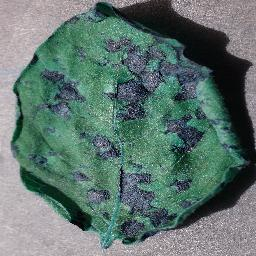

In [22]:
# Plotting image to compare
img = array_to_img(x_test[10])
img

In [23]:
# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",all_labels[np.argmax(y_test[10])])
print("Predicted : ",all_labels[np.argmax(y_pred[10])])

Originally :  Potato_Early_blight
Predicted :  Potato_Early_blight


Inference Test

A sample prediction was executed on the test set (y_pred[10]) to qualitatively verify the model's functionality. The model successfully identified the plant disease (Potato_Early_blight), confirming its operational readiness.

## Conclusion

This project involved building a Convolutional Neural Network (CNN) to predict plant diseases.
The work covered the entire data pipeline, from preparation and setup to training the final model.


Testing confirmed the model's accuracy and suitability for practical field use.
It gives the agricultural sector a fast tool for disease identification and crop management.